In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class BruteOSFMetric(metrics.BaseMetric):
    """Assume I can't trust the slewtime or visittime colums"""
    def __init__(self, metricName='BruteOSFMetric',
            expTimeCol='expTime', mjdCol='expMJD', maxgap=10., fudge=0, **kwargs):
        self.expTimeCol = expTimeCol
        self.maxgap = maxgap/60./24. # convert from min to days
        self.mjdCol = mjdCol
        self.fudge = fudge
        super(BruteOSFMetric, self).__init__(col=[self.expTimeCol, mjdCol],
                                                        metricName=metricName, units='OpenShutter/TotalTime',
                                                        **kwargs)
                                                                                                        
    def run(self, dataSlice, slicePoint=None):
        times = np.sort(dataSlice[self.mjdCol])
        diff = np.diff(times)
        good = np.where(diff < self.maxgap)
        openTime = np.sum(diff[good])*24.*3600.
        result = np.sum(dataSlice[self.expTimeCol]+self.fudge) / float(openTime)
        return result


In [3]:
conns = []
colmap_dicts = []
conns.append(db.SimpleDatabase('opsim3_61_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'expTime', 'visittime': 'expTime', 'mjd':'expMJD'})



conns.append(db.SimpleDatabase('opsimblitz2_1060_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})


conns.append(db.SimpleDatabase('enigma_1189_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})


conns.append(db.SimpleDatabase('minion_1016_sqlite.db', defaultTable='Summary', groupBy='expMJD',
                               defaultdbTables={'Summary': ['Summary', 'obsHistID']}))
colmap_dicts.append({'slewtime': 'slewTime', 'exptime': 'visitExpTime', 'visittime': 'visitTime', 'mjd':'expMJD'})



In [4]:
results = []
i=0
for conn,colmap_dict in zip(conns, colmap_dicts):
    bundleList = []
    sql = ''
    slicer = slicers.UniSlicer()
    if i == 0:
        fudge = -4.
    else:
        fudge = 0.
    i += 1
    metric = BruteOSFMetric(expTimeCol=colmap_dict['exptime'],
                                   mjdCol=colmap_dict['mjd'], fudge=fudge)
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    metric = metrics.MedianMetric(col='normairmass')
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    metric = metrics.MedianMetric(col=colmap_dict['slewtime'])
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    group = metricBundles.MetricBundleGroup(bd, conn)
    group.runAll()
    results.append(bundleList)

Querying database Summary with no constraint for columns ['slewTime', 'airmass', 'fieldDec', 'expTime', 'expMJD'].
Found 2651588 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewTime_UNIS', 'opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with no constraint for columns ['slewTime', 'airmass', 'fieldDec', 'visitExpTime', 'expMJD'].
Found 2551637 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewTime_UNIS', 'opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database Summary with no constraint for columns ['slewTime', 'airmass', 'fieldDec', 'visitExpTime', 'expMJD'].
Found 2469307 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewTime_UNIS', 'opsim_Median_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Complete

In [5]:
osf = [bl[0].metricValues for bl in results]
normAir = [bl[1].metricValues for bl in results]

In [6]:
normAir

[masked_array(data = [1.0958415071696619],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.1234914484593699],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.0775495831422173],
              mask = [False],
        fill_value = -666.0), masked_array(data = [1.073198000531009],
              mask = [False],
        fill_value = -666.0)]

In [7]:
osf

[masked_array(data = [0.7431762502397868],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7555777866507578],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.7333276606428204],
              mask = [False],
        fill_value = -666.0), masked_array(data = [0.735662801166647],
              mask = [False],
        fill_value = -666.0)]

In [12]:
conns = []
colmap_dicts = []
conns.append(db.SimpleDatabase('marching_d365.db', defaultTable='SummaryAllProps',
                               defaultdbTables={'SummaryAllProps': ['SummaryAllProps', 'observationId']}))
colmap_dicts.append({'slewtime': 'slewtime', 'exptime': 'exptime', 'visittime': 'exptime', 'mjd':'mjd'})



In [25]:
results = []
i=0
for conn,colmap_dict in zip(conns, colmap_dicts):
    bundleList = []
    sql = ''
    slicer = slicers.UniSlicer()
    metric = BruteOSFMetric(expTimeCol=colmap_dict['exptime'],
                                   mjdCol=colmap_dict['mjd'], fudge=fudge)
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    stacker = stackers.NormAirmassStacker(decCol='dec')
    metric = metrics.MedianMetric(col='normairmass')
    bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
    bundleList.append(bundle)
    
    metric = metrics.MedianMetric(col=colmap_dict['slewtime'])
    bundle = metricBundles.MetricBundle(metric, slicer, sql)
    bundleList.append(bundle)
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    group = metricBundles.MetricBundleGroup(bd, conn)
    group.runAll()
    results.append(bundleList)

Querying database SummaryAllProps with no constraint for columns ['mjd', 'airmass', 'dec', 'exptime', 'slewtime'].
Found 297317 visits
Running:  ['opsim_BruteOSFMetric_UNIS', 'opsim_Median_slewtime_UNIS', 'opsim_Mean_normairmass_UNIS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [26]:
feature_osf = bundleList[0].metricValues
feature_nair = bundleList[1].metricValues

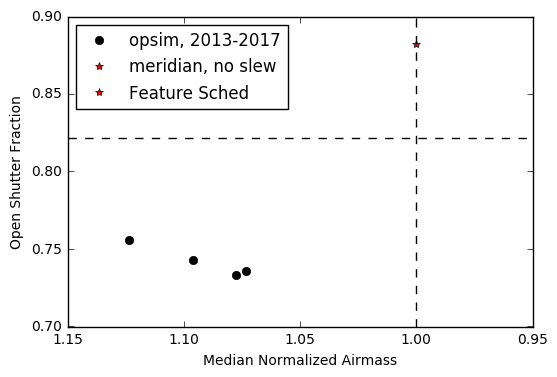

In [16]:
max_osf = 30./(34)
plt.plot(normAir, osf, 'ko', label='opsim, 2013-2017')
plt.xlim([1.15, .95])
plt.ylim([.7, .9])
plt.plot(1, max_osf, 'r*', label='meridian, no slew')
plt.xlabel('Median Normalized Airmass')
plt.ylabel('Open Shutter Fraction')
plt.axhline(y=30./(32.+4.5), linestyle='--', color='k')
plt.axvline(x=1., linestyle='--', color='k')

plt.plot(feature_nair, feature_osf, 'r*', label='Feature Sched')

plt.legend(scatterpoints=1, numpoints=1, loc='upper left')

In [17]:

feature_osf

masked_array(data = [0.7792103320356255],
             mask = [False],
       fill_value = -666.0)

In [27]:
feature_nair


masked_array(data = [1.4892683182332174],
             mask = [False],
       fill_value = -666.0)

Querying database SummaryAllProps with no constraint for columns ['airmass', 'dec'].
Found 297317 visits
Running:  ['opsim_Count_normairmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


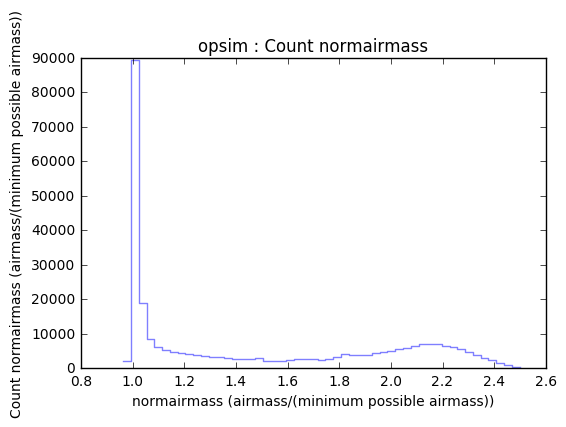

In [24]:
bundleList = []

slicer = slicers.OneDSlicer(sliceColName='normairmass')
stacker = stackers.NormAirmassStacker(decCol='dec')
metric = metrics.CountMetric(col='normairmass')
bundle = metricBundles.MetricBundle(metric, slicer, sql, stackerList=[stacker])
bundleList.append(bundle)


bd = metricBundles.makeBundlesDictFromList(bundleList)
group = metricBundles.MetricBundleGroup(bd, conn)
group.runAll()
group.plotAll(closefigs=False)

In [22]:
help(slicers.OneDSlicer)

Help on class OneDSlicer in module lsst.sims.maf.slicers.oneDSlicer:

class OneDSlicer(lsst.sims.maf.slicers.baseSlicer.BaseSlicer)
 |  oneD Slicer.
 |  
 |  Method resolution order:
 |      OneDSlicer
 |      lsst.sims.maf.slicers.baseSlicer.BaseSlicer
 |      future.types.newobject.newobject
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, otherSlicer)
 |      Evaluate if slicers are equivalent.
 |  
 |  __init__(self, sliceColName=None, sliceColUnits=None, bins=None, binMin=None, binMax=None, binsize=None, verbose=True, badval=0)
 |      'sliceColName' is the name of the data column to use for slicing.
 |      'sliceColUnits' lets the user set the units (for plotting purposes) of the slice column.
 |      'bins' can be a numpy array with the binpoints for sliceCol or a single integer value
 |      (if a single value, this will be used as the number of bins, together with data min/max or binMin/Max),
 |      as in numpy's histogram function.
 |      If 